In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from datetime import datetime,timedelta
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import Adam
from keras.layers.recurrent import LSTM
# from keras_tqdm import TQDMNotebookCallback
from ipywidgets import interact

# from bokeh.io import push_notebook, show, output_notebook
# from bokeh.plotting import figure
# output_notebook()
# import mpld3
# mpld3.enable_notebook()

% matplotlib inline

print("All dependencies imported!! TF: {} ; Keras :{}".format(tf.__version__,keras.__version__))

!(date +%d\ %B\ %G)

Using TensorFlow backend.


All dependencies imported!! TF: 1.0.0 ; Keras :2.0.6
22 August 2017


# Load Helper Functions

In [5]:
def load_encoders():
    src_encoder = LabelEncoder()
    dst_encoder = LabelEncoder()
    type_encoder = LabelEncoder()
    activity_encoder = LabelEncoder()
    protocol_encoder = LabelEncoder()
    t_endpoint_encoder = LabelEncoder()
    
    src_encoder.classes_ = np.load('encoders/ddm_rse_endpoints.npy')
    dst_encoder.classes_ = np.load('encoders/ddm_rse_endpoints.npy')
    type_encoder.classes_ = np.load('encoders/type.npy')
    activity_encoder.classes_ = np.load('encoders/activity.npy')
    protocol_encoder.classes_ = np.load('encoders/protocol.npy')
    t_endpoint_encoder.classes_ = np.load('encoders/endpoint.npy')
    
    return (src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder)

def train_encoders(rucio_data, use_cache=True):
    
    if use_cache:
        if os.path.isfile('encoders/ddm_rse_endpoints.npy') and os.path.isfile('encoders/activity.npy'):
            print('using cached LabelEncoders for encoding data.....')
            src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder=load_encoders()
        else:
            print('NO cache found')
    else:
        print('No cached encoders found ! Training Some New Ones using input data!')
        src_encoder = LabelEncoder()
        dst_encoder = LabelEncoder()
        type_encoder = LabelEncoder()
        activity_encoder = LabelEncoder()
        protocol_encoder = LabelEncoder()
        t_endpoint_encoder = LabelEncoder()

        src_encoder.fit(rucio_data['src-rse'].unique())
        dst_encoder.fit(rucio_data['dst-rse'].unique())
        type_encoder.fit(rucio_data['src-type'].unique())
        activity_encoder.fit(rucio_data['activity'].unique())
        protocol_encoder.fit(rucio_data['protocol'].unique())
        t_endpoint_encoder.fit(rucio_data['transfer-endpoint'].unique())

        np.save('encoders/src.npy', src_encoder.classes_)
        np.save('encoders/dst.npy', dst_encoder.classes_)
        np.save('encoders/type.npy', type_encoder.classes_)
        np.save('encoders/activity.npy', activity_encoder.classes_)
        np.save('encoders/protocol.npy', protocol_encoder.classes_)
        np.save('encoders/endpoint.npy', t_endpoint_encoder.classes_)
    
    return (src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder)

def preprocess_data(rucio_data, use_cache=True):
    
    fields_to_drop = ['account','reason','checksum-adler','checksum-md5','guid','request-id','transfer-id','tool-id',
                      'transfer-link','previous-request-id','src-url','dst-url', 'Unnamed: 0']
    timestamps = ['started_at', 'submitted_at','transferred_at']

    #DROP FIELDS , CHANGE TIME FORMAT, add dataetime index
    rucio_data = rucio_data.drop(fields_to_drop, axis=1)
    for timestamp in timestamps:
        rucio_data[timestamp]= pd.to_datetime(rucio_data[timestamp], infer_datetime_format=True)
    rucio_data['delay'] = rucio_data['started_at'] - rucio_data['submitted_at']
    rucio_data['delay'] = rucio_data['delay'].astype('timedelta64[s]')
    
    rucio_data = rucio_data.sort_values(by='submitted_at')
    
    # Reindex data with 'submitted_at timestamp'
    rucio_data.index = pd.DatetimeIndex(rucio_data['submitted_at'])
    
    #remove all timestamp columns
    rucio_data = rucio_data.drop(timestamps, axis=1)
    
    # encode categorical data
 
    if use_cache==True:
        src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder = train_encoders(rucio_data, use_cache=True)
    else:
        src_encoder,dst_encoder,type_encoder,activity_encoder,protocol_encoder,t_endpoint_encoder = train_encoders(rucio_data, use_cache=False)

    rucio_data['src-rse'] = src_encoder.transform(rucio_data['src-rse'])
    rucio_data['dst-rse'] = dst_encoder.transform(rucio_data['dst-rse'])
    rucio_data['src-type'] = type_encoder.transform(rucio_data['src-type'])
    rucio_data['dst-type'] = type_encoder.transform(rucio_data['dst-type'])
    rucio_data['activity'] = activity_encoder.transform(rucio_data['activity'])
    rucio_data['protocol'] = protocol_encoder.transform(rucio_data['protocol'])
    rucio_data['transfer-endpoint'] = t_endpoint_encoder.transform(rucio_data['transfer-endpoint'])
    
    return rucio_data


def rescale_data(rucio_data, durations):
    # Normalization
    # using custom scaling parameters (based on trends of the following variables)

#     durations = durations / 1e3
    rucio_data['bytes'] = rucio_data['bytes'] / 1e8
    rucio_data['delay'] = rucio_data['delay'] / 1e3
#     rucio_data['src-rse'] = rucio_data['src-rse'] / 1e2
#     rucio_data['dst-rse'] = rucio_data['dst-rse'] / 1e2
    
    return rucio_data, durations


# get data

In [6]:
rucio_data = pd.read_csv('data/atlas_rucio-events-2017.08.06.csv')

In [7]:
import os
rucio_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 959538 entries, 0 to 959537
Data columns (total 27 columns):
Unnamed: 0             959538 non-null int64
account                0 non-null float64
activity               959538 non-null object
bytes                  959538 non-null int64
checksum-adler         959538 non-null object
checksum-md5           0 non-null float64
dst-rse                959538 non-null object
dst-type               959538 non-null object
dst-url                959538 non-null object
duration               959538 non-null int64
guid                   0 non-null float64
name                   959538 non-null object
previous-request-id    13022 non-null object
protocol               959538 non-null object
reason                 0 non-null float64
request-id             959538 non-null object
scope                  959538 non-null object
src-rse                959538 non-null object
src-type               959538 non-null object
src-url                959538 non-n

In [8]:
rucio_data = preprocess_data(rucio_data)
rucio_data.head()

using cached LabelEncoders for encoding data.....


,activity,bytes,dst-rse,dst-type,duration,name,protocol,scope,src-rse,src-type,transfer-endpoint,delay
submitted_at,,,,,,,,,,,,
2017-07-30 00:29:31,11,8480,219,0,22,user.llorente.11797061._037293.hist-output.root,2,user.llorente,703,0,3,604389.0
2017-07-30 00:46:25,1,1471604076,216,0,3243,DAOD_MUON1.11728785._000063.pool.root.1,2,mc16_13TeV,482,0,3,604534.0
2017-07-30 00:58:25,11,25038964,219,0,68,user.jolsson.11795997.EXT0._000866.pool.root,2,user.jolsson,494,0,3,600409.0
2017-07-30 01:10:42,11,24618882,219,0,130,user.jolsson.11795990.EXT0._001825.pool.root,2,user.jolsson,494,0,3,600388.0
2017-07-30 01:39:42,1,331343756,216,0,1223,DAOD_SUSY8.11731924._000102.pool.root.1,2,mc15_13TeV,482,0,3,604597.0


In [9]:
indices = rucio_data.index
names=rucio_data['name']
scopes=rucio_data['scope']
durations = rucio_data['duration']
rucio_data = rucio_data.drop(['name','duration', 'scope'], axis=1)
rucio_data = rucio_data[['bytes', 'delay', 'activity', 'dst-rse', 'dst-type',
             'protocol', 'src-rse', 'src-type', 'transfer-endpoint']]
rucio_data, durations = rescale_data(rucio_data, durations)


In [10]:
durations.shape

(959538,)

In [11]:
train_fraction = 0.9
data_size = rucio_data.shape[0]
split_index = int(train_fraction * data_size)
# print(split_index)
trainX,trainY,testX,testY=rucio_data[:split_index],durations[:split_index],rucio_data[split_index:],durations[split_index:]


In [14]:
print(trainX.shape,'\t', trainY.shape)

(863584, 9) 	 (863584,)


In [15]:
import keras.callbacks as cb

class LossHistory(cb.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        batch_loss = logs.get('loss')
        self.losses.append(batch_loss)

In [16]:
def run_network(model=None, epochs=20, batch=256):
    try:
        start_time = time.time()

        if model is None:
            model = init_model()
            print(model.summary())

        history = LossHistory()

        print('Training Feedforward network...')
        training = model.fit(trainX.as_matrix(), trainY.as_matrix(), epochs=epochs, batch_size=batch,
                             validation_split=0.1, callbacks=[history], verbose=1)

        print("Training duration : {0}".format(time.time() - start_time))
        score = model.evaluate(trainX.as_matrix(), trainY.as_matrix(), verbose=0)

        print("Network's training score [MSE]: {0}; in seconds:{1}".format(score, np.sqrt(score)))
        print("Training finished !!!!!!")
        return training, model, history.losses
    except KeyboardInterrupt:
        print('KeyboardInterrupt')
        return model, history.losses

In [17]:
def plot_losses(losses):
    sns.set_context('poster')
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(losses)
    ax.set_title('Loss per batch')
    fig.show()
    print(len(losses))

# Starting Training with different network architectures

In [18]:
import time

In [24]:
def init_model():
    start_time= time.time()
    print('Compiling model ...')
    
    model = Sequential()
    model.add(Dense(512, input_dim=9,init='normal', activation='tanh'))

    model.add(Dense(512,init='normal', activation='linear'))
    model.add(LeakyReLU(alpha=0.001))

    model.add(Dense(512, init='normal', activation='tanh'))
    model.add(Dense(256, init='normal', activation='relu'))  # relu
    # model.add(LeakyReLU(alpha=0.001))

    model.add(Dense(256, init='normal', activation='linear'))
    model.add(Dense(256, init='normal', activation = 'relu'))  # extra
    model.add(Dense(128, init='normal', activation='relu'))    # relu
    model.add(Dense(1))
    
    adam = Adam(lr=0.001, decay= 0.0002)
    #adam = Adam(lr=0.01, decay = 0.0001)
#     adam = Adam()
    model.compile(loss='mean_squared_error', optimizer=adam)
    print('Model compield in {0} seconds'.format(time.time() - start_time))
    return model

Compiling model ...
Model compield in 0.09571480751037598 seconds
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 512)               5120      
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_15 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_16 (

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="normal", input_dim=9, activation="tanh")`
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="normal", activation="linear")`
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="normal", activation="tanh")`
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="normal", activation="relu")`
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="n

Train on 777225 samples, validate on 86359 samples
Epoch 1/20
777225/777225 [==============================] - 7s - loss: 88866.9269 - val_loss: 52901.6559

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


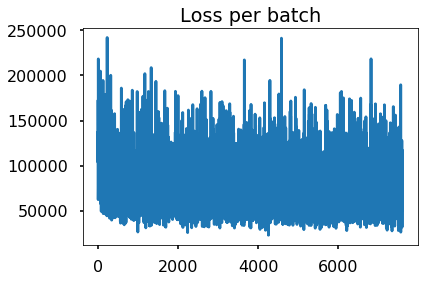

In [25]:
training, model, losses = run_network(epochs= 20, batch=2048)
plot_losses(losses)

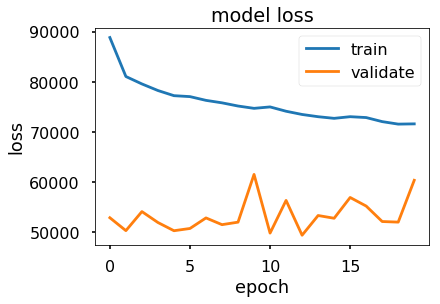

Results: MSE - 28599.224786  ;  seconds = 169.113


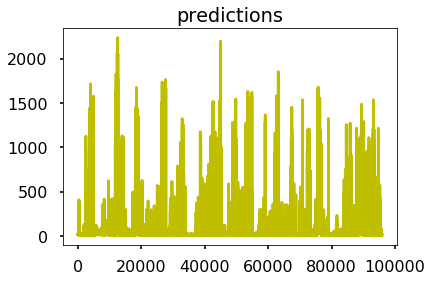

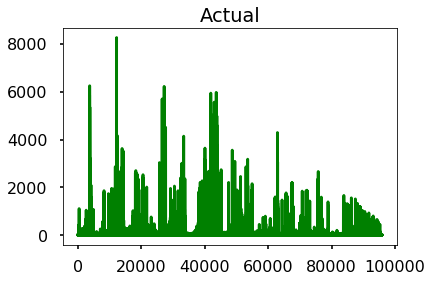

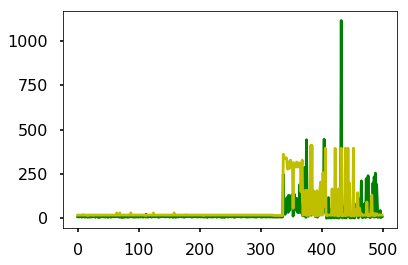

In [26]:
sns.set_context('poster')

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

score = model.evaluate(testX.as_matrix(), testY.as_matrix(), verbose=2)

print('Results: MSE - {:.6f}  ;  seconds = {:.3f}'.format(score, np.sqrt(score)))

predictions=model.predict((testX).as_matrix())

sns.set_context('poster')

# plotting a portion of the test values against the predicted output

plt.plot(predictions,'y' )
plt.title('predictions')
plt.show()
plt.plot(testY.as_matrix(), 'g')
plt.title('Actual')
plt.show()

plt.plot(testY[:500].as_matrix(), 'g')
plt.plot(predictions[:500], 'y')
plt.show()

In [27]:
model_json = model.to_json()
with open("models/ff2_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/ff2_model.h5")
print("Saved model to disk")


Saved model to disk


# model-2

In [28]:

def init_model():
    start_time= time.time()
    print('Compiling model ...')
    
    model = Sequential()
    model.add(Dense(1024, input_dim=9,init='normal', activation='relu'))

    model.add(Dense(512,init='normal', activation='linear'))
    model.add(LeakyReLU(alpha=0.001))

    model.add(Dense(256, init='normal', activation='relu'))
    model.add(Dense(128, init='normal', activation='relu'))  # relu
    # model.add(LeakyReLU(alpha=0.001))

    model.add(Dense(64, init='normal', activation='relu'))
    model.add(Dense(32, init='normal', activation = 'relu'))  # extra
    model.add(Dense(16, init='normal', activation='relu'))    # relu
    model.add(Dense(1))
    
    #adam = Adam(lr=0.001, decay= 0.0002)
    #adam = Adam(lr=0.01, decay = 0.0001)
    adam = Adam()
    model.compile(loss='mean_squared_error', optimizer=adam)
    print('Model compield in {0} seconds'.format(time.time() - start_time))
    return model

Compiling model ...
Model compield in 0.09629487991333008 seconds
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 1024)              10240     
_________________________________________________________________
dense_20 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_22 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_23 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_24 (

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1024, kernel_initializer="normal", input_dim=9, activation="relu")`
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="normal", activation="linear")`
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="normal", activation="relu")`
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:13: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, kernel_initializer="normal", activation="relu")`
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, kernel_initializer="n

Train on 777225 samples, validate on 86359 samples
Epoch 1/20
777225/777225 [==============================] - 7s - loss: 89367.3785 - val_loss: 49222.0999

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


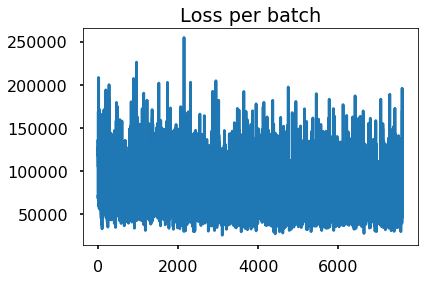

In [29]:
training, model, losses = run_network(epochs= 20, batch=2048)
plot_losses(losses)

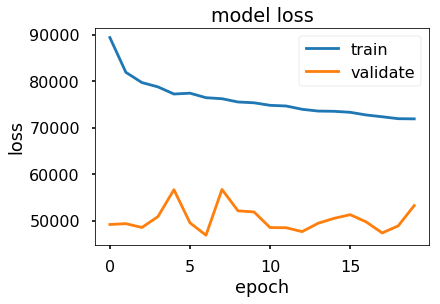

Results: MSE - 31007.456944  ;  seconds = 176.089


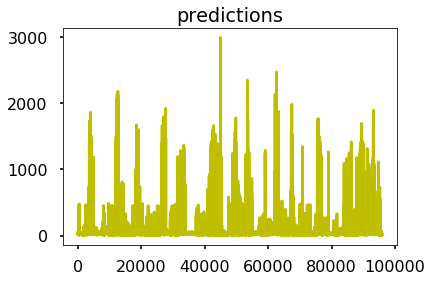

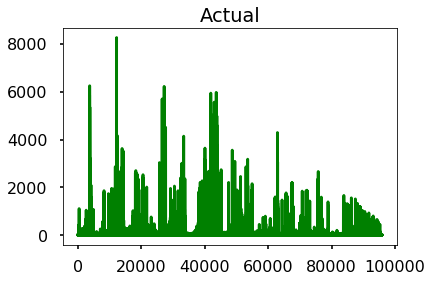

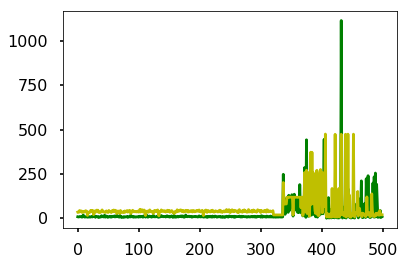

In [30]:
sns.set_context('poster')

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

score = model.evaluate(testX.as_matrix(), testY.as_matrix(), verbose=2)

print('Results: MSE - {:.6f}  ;  seconds = {:.3f}'.format(score, np.sqrt(score)))

predictions=model.predict((testX).as_matrix())

sns.set_context('poster')

# plotting a portion of the test values against the predicted output

plt.plot(predictions,'y' )
plt.title('predictions')
plt.show()
plt.plot(testY.as_matrix(), 'g')
plt.title('Actual')
plt.show()

plt.plot(testY[:500].as_matrix(), 'g')
plt.plot(predictions[:500], 'y')
plt.show()

In [31]:
model_json = model.to_json()
with open("models/ff3_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/ff3_model.h5")
print("Saved model to disk")


Saved model to disk


# model-3 -- deeper 

In [19]:

def init_model():
    start_time= time.time()
    print('Compiling model ...')
    
    model = Sequential()
    model.add(Dense(512, input_dim=9,init='normal', activation='relu'))

    model.add(Dense(512,init='normal', activation='linear'))
    model.add(LeakyReLU(alpha=0.001))
    
    model.add(Dense(512, init='normal'))
    model.add(LeakyReLU(alpha=0.001))
    
    model.add(Dense(512, init='normal'))
    model.add(LeakyReLU(alpha=0.001))

    model.add(Dense(256, init='normal', activation='relu'))
    model.add(Dense(128, init='normal', activation='relu'))  # relu
    # model.add(LeakyReLU(alpha=0.001))

    model.add(Dense(64, init='normal', activation='relu'))
    model.add(Dense(32, init='normal', activation = 'relu'))  # extra
    model.add(Dense(16, init='normal', activation='relu'))    # relu
    model.add(Dense(1))
    
    #adam = Adam(lr=0.001, decay= 0.0002)
    #adam = Adam(lr=0.01, decay = 0.0001)
    adam = Adam()
    model.compile(loss='mean_squared_error', optimizer=adam)
    print('Model compield in {0} seconds'.format(time.time() - start_time))
    return model

Compiling model ...
Model compield in 0.12175107002258301 seconds
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               5120      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_l

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="normal", input_dim=9, activation="relu")`
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:9: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="normal", activation="linear")`
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="normal")`
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, kernel_initializer="normal")`
/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, kernel_initializer="normal", activation="relu")`
/home/carn

Train on 777225 samples, validate on 86359 samples
Epoch 1/20
777225/777225 [==============================] - 10s - loss: 89290.7574 - val_loss: 50081.7451

/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


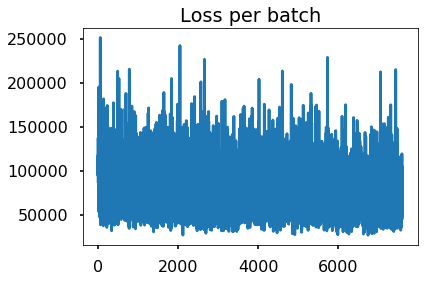

In [20]:
training, model, losses = run_network(epochs= 20, batch=2048)
plot_losses(losses)

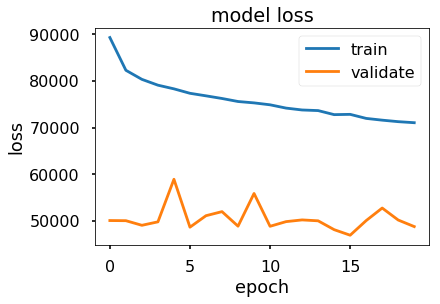

Results: MSE - 30574.449804  ;  seconds = 174.856


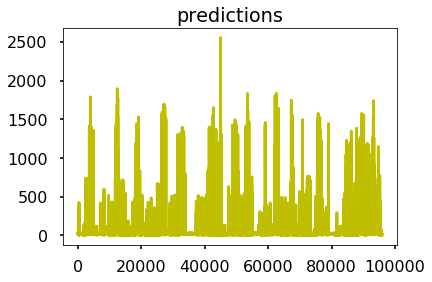

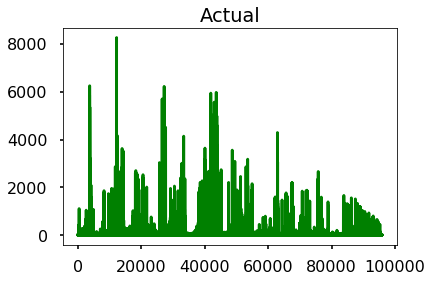

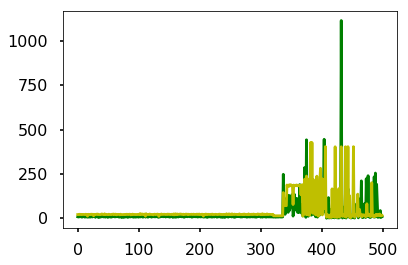

In [21]:
sns.set_context('poster')

plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

score = model.evaluate(testX.as_matrix(), testY.as_matrix(), verbose=2)

print('Results: MSE - {:.6f}  ;  seconds = {:.3f}'.format(score, np.sqrt(score)))

predictions=model.predict((testX).as_matrix())

sns.set_context('poster')

# plotting a portion of the test values against the predicted output

plt.plot(predictions,'y' )
plt.title('predictions')
plt.show()
plt.plot(testY.as_matrix(), 'g')
plt.title('Actual')
plt.show()

plt.plot(testY[:500].as_matrix(), 'g')
plt.plot(predictions[:500], 'y')
plt.show()

In [22]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               5120      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 512)               0         
__________

In [23]:
model_json = model.to_json()
with open("models/ff_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("models/ff_model.h5")
print("Saved model to disk")


Saved model to disk
